# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [2]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
adata = sc.read(folder_path + "preprocessed_adata.h5ad")

In [17]:
adata

AnnData object with n_obs × n_vars = 143488 × 42950
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [21]:
sc.pp.filter_genes(adata, min_cells=30)
adata

AnnData object with n_obs × n_vars = 143488 × 30135
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [11]:
adata.obs.groupby(['sample']).count()
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_95516\3385959805.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count()


,n_genes,total_counts,pct_counts_mito,pct_counts_ribo
sample,,,,
Pt1,2633,2633,2633,2633
Pt2,587,587,587,587
Pt3,1408,1408,1408,1408
Pt4,2239,2239,2239,2239
Pt5,6403,6403,6403,6403
Pt6,2528,2528,2528,2528
Pt7,1418,1418,1418,1418
Pt8,6671,6671,6671,6671
Pt9,11507,11507,11507,11507


# batch 확인

In [12]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# running time: 2m 8s

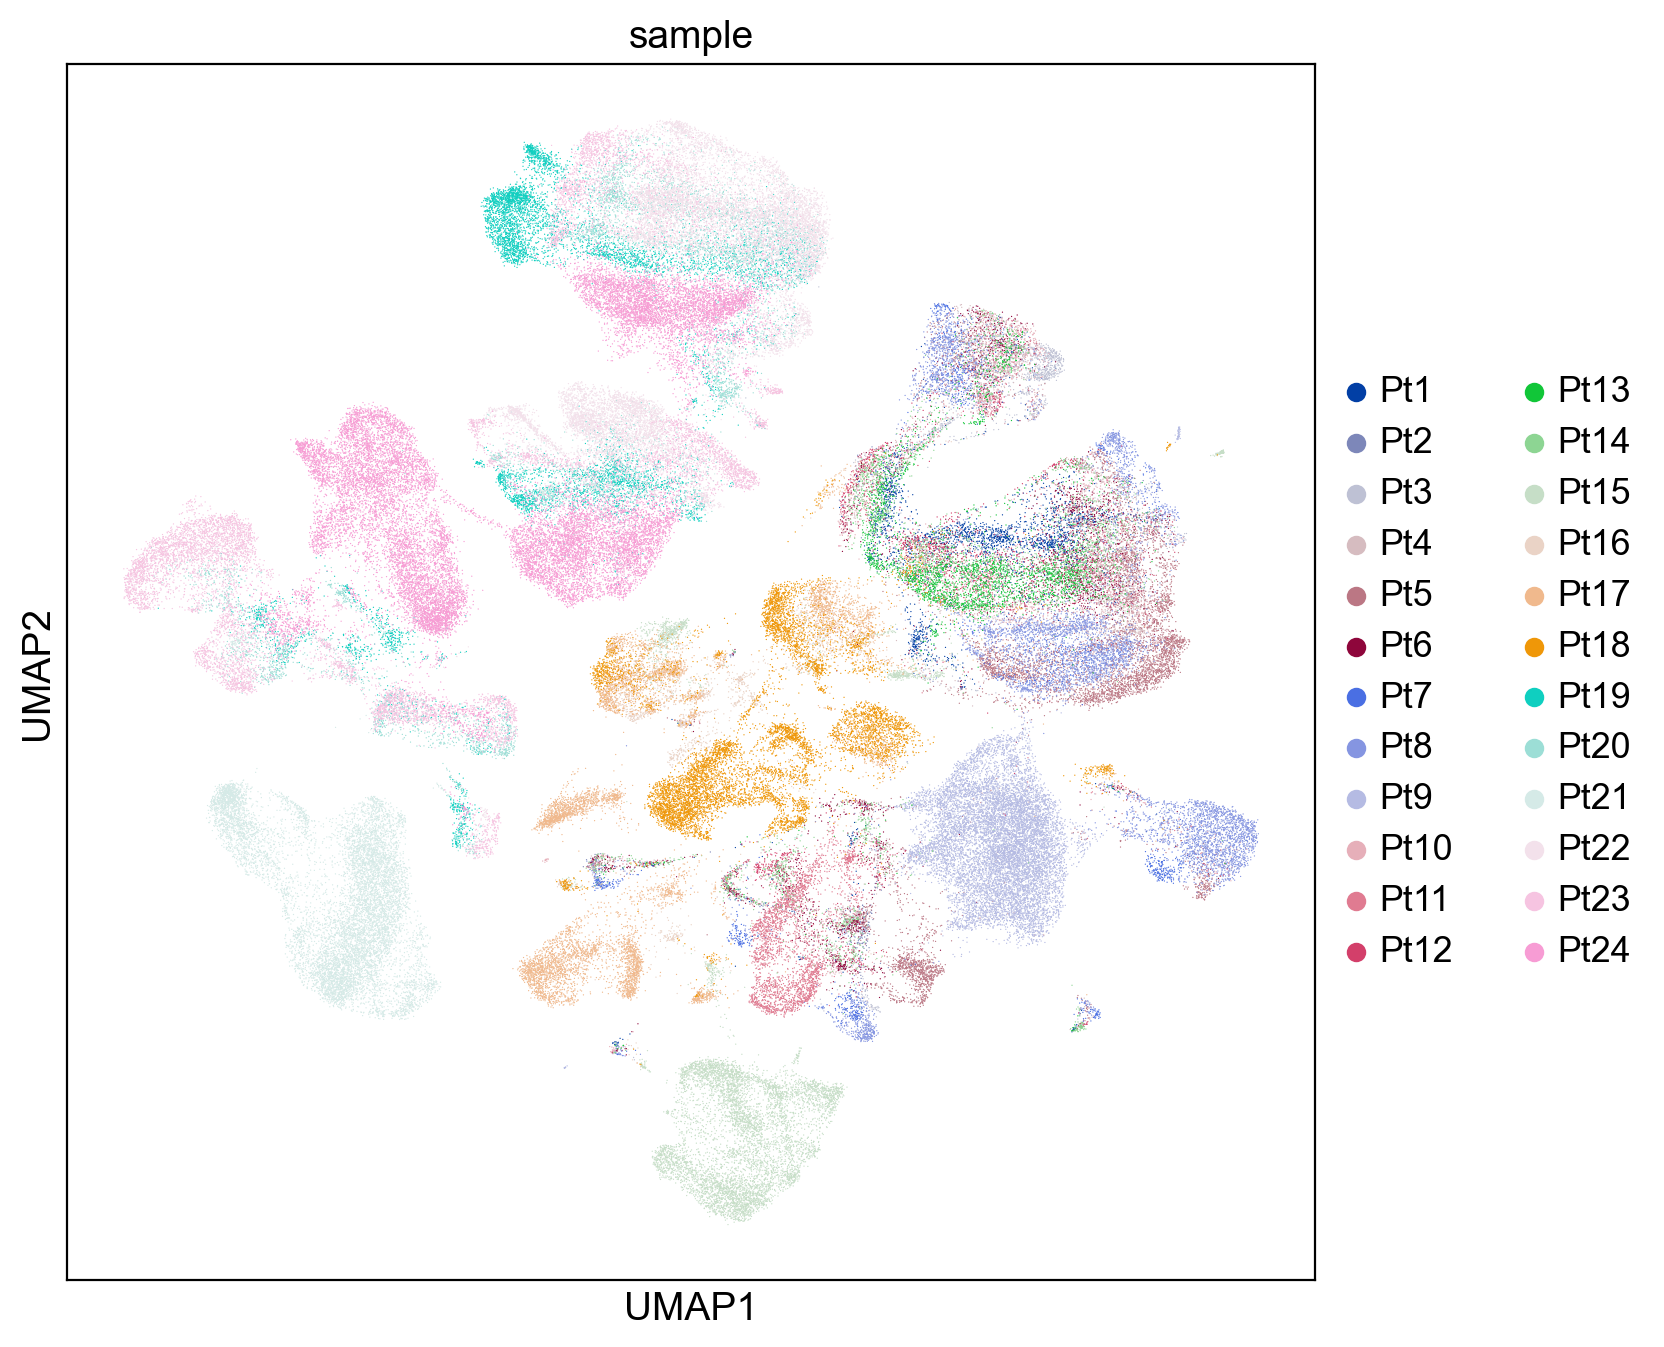

In [22]:
sc.settings.set_figure_params(dpi=100, figsize = (8, 8))
sc.pl.umap(
    adata,
    color = 'sample',
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'condition')

In [23]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수
# 37k cells and 16k genes, 215 epochs, RTX3070 -> 약 11분 소요
# 143k cells and 30k genes, 56 epochs, RTX3070 -> 약 18분 소요
scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    categorical_covariate_keys = ['sample'],  # sample 별로 batch effect 제거
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'])
model = scvi.model.SCVI(adata)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 56/56: 100%|██████████| 56/56 [17:24<00:00, 18.42s/it, v_num=1, train_loss_step=6.17e+3, train_loss_epoch=6.1e+3] 

`Trainer.fit` stopped: `max_epochs=56` reached.


Epoch 56/56: 100%|██████████| 56/56 [17:24<00:00, 18.65s/it, v_num=1, train_loss_step=6.17e+3, train_loss_epoch=6.1e+3]


In [24]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

# running time: 40s

# Batch regression 확인

In [25]:
# 기본적인 clustering
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s

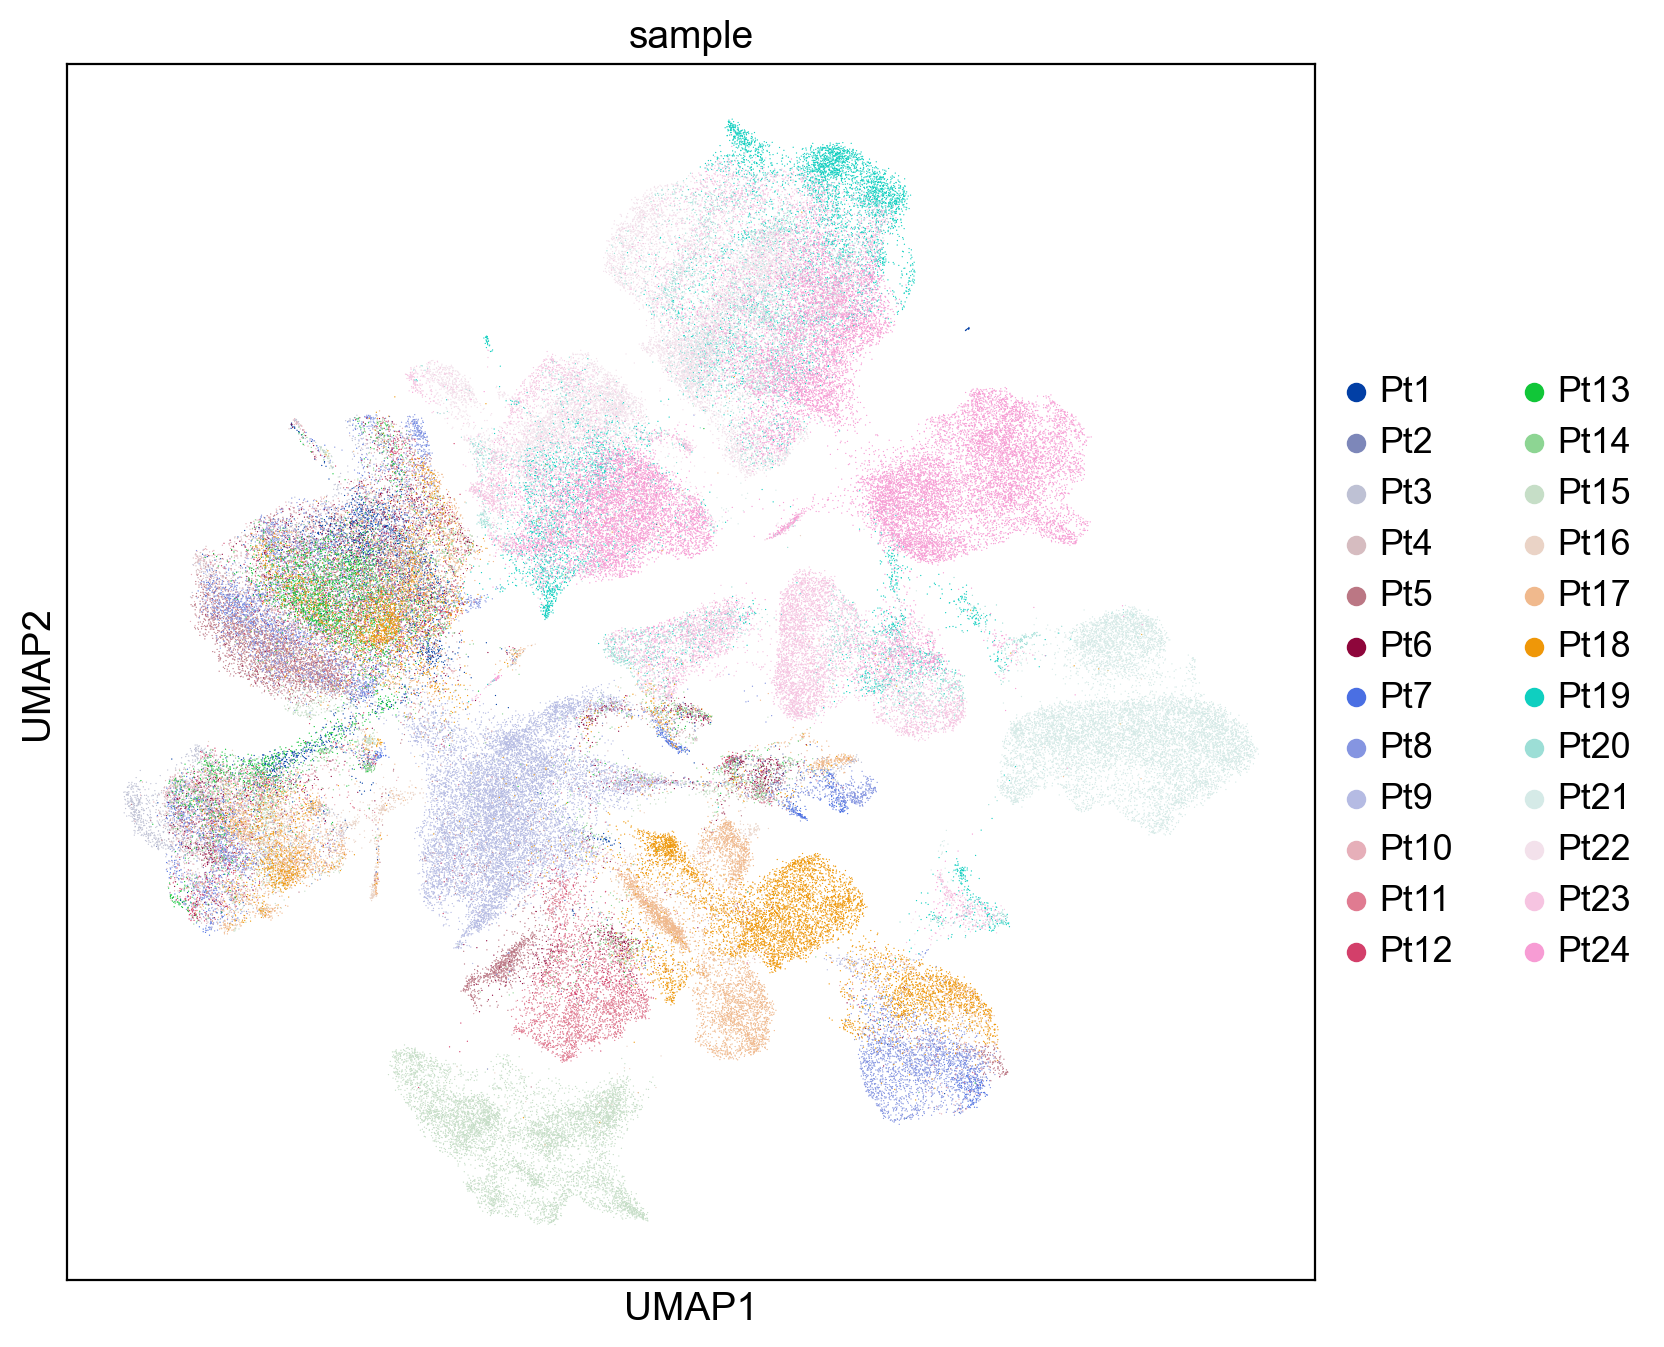

In [26]:
sc.settings.set_figure_params(dpi=100, figsize = (8, 8))
sc.pl.umap(
    adata,
    color = 'sample',
)

> batch effect 안없어진거 처럼 보이는데 원본 논문 보면 tumor에서 새 population이 생기는게 맞는거 같기도 하고..\
> UMAP 그림은 원본 논문과 가장 비슷하게 나오긴 한다.\

In [27]:
adata

AnnData object with n_obs × n_vars = 143488 × 30135
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

# Save the integrated data and scVI model

In [28]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장